### **Rozkład prawdopodobieństwa** można traktować jako model opisujący dane. <br> 
O takim modelu możemy mysleć jak o generatorze liczb losowych, który zwraca wyniki o rozkładzie zbliżonym do rozkładu rzeczywistych danych. *Model generatywny* to taki, który potrafi wygenerować syntetyczne dane <font color='orange'>podobne do danych rzeczywistych</font>. <br>
Jak dopasowywać rozkłady do danych? <br>
Oto plan notatnika.


*   **Estymatory parametryczne**, np. z metody maksymalnej wiarygodności.
*   Weryfikacja hipotez dotyczących rozkładów: czy dane pochodzą z określonego rozkładu?
*   **Estymatory nieparametryczne**, np. estymator Parzena.



**Uwaga techniczna**<br>
Zakładam, że:
*   potrafisz rozróżniać między rozkładami dla zmiennych dyskretnych a funkcjami
gęstości dla zmiennych ciągłych, 
*   wiesz, czym różni się prawdopodobieństwo (ang. *probability*) od wiarygodności (ang. *likelihood*),
*   znasz procedurę wyznaczania z funkcji gęstości $f(x)$ prawdopodobieństwa, że losowa wartość $x$ wpadnie do określonego przedziału. 

W języku angielskim zachodzi miły zbieg okoliczności, że rozkład prawdopodobieństwa nosi nazwę *Probability Distribution Function* a funkcja gęstości *Probability Density Function*, co w obu przypadkach pozwala stosować ten sam skrót *PDF*. Z językowej zazdrości i dla uproszczenia opisów używałem i używać będę określenia *rozkład* w przypadku zarówno dyskretnym jak i ciągłym, a Ty będziesz domyślać się z kontekstu, czy chodzi o *rozkład prawdopodobieństwa*, czy o funkcję gęstości.

In [1]:
%matplotlib inline

In [10]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os

#### **Estymator parametryczny** <br>
Wzór opisujący rozkład jest z góry określony. <br>
Wzór ten ma pewne swobodne parametry, których wartości należy estymować z danych. <br>
Postać rozkładu nie zależy od liczby obserwacji zawartych w zbiorze danych. <br>
Wartości parametrów rozkładu wyznaczane są w procesie optymalizacji (analitycznej lub numerycznej).

Przedstawione dane pomiarowe dotyczą studentów kierunku Inżynieria systemów; zostały zebrane w roku 2020.

In [3]:
plik = 'pomiary2020.xlsx'
URL = "https://byes.pl/wp-content/uploads/datasets/" + plik
if not os.path.isfile(plik):
    print('Pobieram plik z ', URL)
    urllib.request.urlretrieve(URL, plik)
    print('Pobrano plik')
else:
    print(f'Plik {plik} już jest na dysku')

dane = pd.read_excel(plik) 
dane.sample(4)

Pobieram plik z  https://byes.pl/wp-content/uploads/datasets/pomiary2020.xlsx
Pobrano plik


,waga,wzrost,płeć,puls przed,puls po,czas
22,60.0,184,M,86,83,124
9,80.0,180,M,55,102,165
14,71.0,170,K,91,131,59
2,68.0,178,M,85,99,180


Wybierzemy jedną cechę do opisu statystycznego rozkładem normalnym:
\begin{equation}
f(x; \mu, \sigma)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right].
\tag{1}
\end{equation}

In [4]:
cecha = 'wzrost'
X = dane[cecha].values
X_mezcz = X[dane['płeć']=='M']
X_kob = X[dane['płeć']=='K']
print(f"Wszystkich: {X.size}\nKobiet: {X_kob.size}\nMężczyzn: {X_mezcz.size}")

Wszystkich: 46
Kobiet: 9
Mężczyzn: 37


In [5]:
def rozklad_norm(parametry, x):
    mu, sigma = parametry
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

Estymacja parametrów rozkładu normalnego dla każdej podgrupy. <br> 
Algorytm metody największej wiarygodności (ang. *Maximum Likelihood method*) podany był na wykładzie. 

In [6]:
mu_wszyscy, sigma_wszyscy = X.mean(), X.std()
mu_mezcz, sigma_mezcz = X_mezcz.mean(), X_mezcz.std()
mu_kob, sigma_kob = X_kob.mean(), X_kob.std()

Ilustracja rozkładów na tle danych, z użyciem biblioteki [```seaborn```](https://seaborn.pydata.org/index.html) dla lepszego efektu.

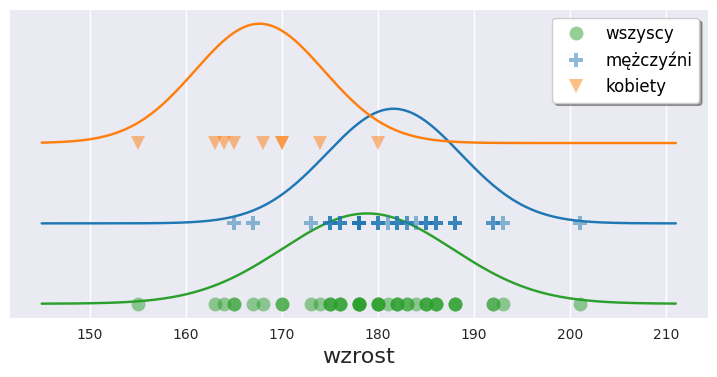

In [12]:
os_x = np.linspace(X.min()-10, X.max()+10, num=300)

os_y_wszyscy = rozklad_norm([mu_wszyscy, sigma_wszyscy], os_x)
os_y_mezcz = rozklad_norm([mu_mezcz, sigma_mezcz], os_x)
os_y_kob = rozklad_norm([mu_kob, sigma_kob], os_x)

with plt.style.context('seaborn-v0_8'):  
    plt.figure(figsize=(9,4))
    plt.plot(X, np.zeros_like(X), 'o', 
             markersize=10, alpha=0.5, markerfacecolor='tab:green', markeredgecolor='tab:green', 
             label='wszyscy')
    plt.plot(os_x, 25*os_y_wszyscy, color='tab:green')
    plt.plot(X_mezcz, np.ones_like(X_mezcz), 'P', 
             markersize=10, alpha=0.5, markerfacecolor='tab:blue', markeredgecolor='tab:blue', 
             label='mężczyźni')
    plt.plot(os_x, 25*os_y_mezcz+1, color='tab:blue')
    plt.plot(X_kob, 2*np.ones_like(X_kob), 'v', 
             markersize=10, alpha=0.5, markerfacecolor='tab:orange', markeredgecolor='tab:orange', 
             label='kobiety')
    plt.plot(os_x, 25*os_y_kob+2, color='tab:orange')
    plt.xlabel(cecha, fontsize=16)
    plt.yticks([])
plt.legend(shadow=True, fontsize=12)
plt.show()

Jak oceniasz, metodą na oko (ang. *visual inspection*), czy opisywanie danych rozkładem normalnym jest uzasadnione dla każdej grupy?

**Weryfikacja hipotez** <br>
Czy te dane w ogóle pochodzą z rozkładu normalnego?

https://www.lukaszderylo.pl/blog/p-value.html


Testów statystycznych do sprawdzania normalności rozkładu danych jest wiele. Każdy bierze pod uwagę inne charakterystyczne cechy rozkładu normalnego (np. test D’Agostino i Pearsona bada skośność i kurtozę) oraz ma różną moc, co oznacza, że jedne łatwiej wykazują normalność danych a inne łatwiej wykazują jej brak. <br>
Wybór testów na zajęcia ze statystyki zależy od preferencji prowadzącego, ale każdy test podlega tej samej standardowej procedurze weryfikacji hipotez statystycznych.    

In [13]:
from scipy import stats

print(f'Cały zbiór | test Shapiro, p-wartość = {stats.shapiro(X)[1]}')
print(f'Cały zbiór | test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X)[1]}\n')

print(f'Podzbiór kobiety | test Shapiro, p-wartość = {stats.shapiro(X_kob)[1]}')
print(f'Podzbiór kobiety | test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X_kob)[1]}\n')

print(f'Podzbiór mężczyźni | test Shapiro, p-wartość = {stats.shapiro(X_mezcz)[1]}')
print(f'Podzbiór mężczyźni | test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X_mezcz)[1]}\n')

Cały zbiór | test Shapiro, p-wartość = 0.741510964211591
Cały zbiór | test D’Agostino i Pearsona, p-wartość = 0.4999461522561214

Podzbiór kobiety | test Shapiro, p-wartość = 0.9649486456726413
Podzbiór kobiety | test D’Agostino i Pearsona, p-wartość = 0.7786066393666938

Podzbiór mężczyźni | test Shapiro, p-wartość = 0.6480432990762417
Podzbiór mężczyźni | test D’Agostino i Pearsona, p-wartość = 0.39159142252762885



/home/tymoteusz/Projects/IdeaProjects/StudiesProjects/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


Czy umiesz zinterpretować te wyniki?

**Zagadka** sprawdzająca Twoje przygotowanie statystyczne. <br>
Jak wyjaśnić poniższe wyniki?

In [14]:
print('=== Test Shapiro ===')
print(f"Dla wagi p-wartość = {stats.shapiro(dane['waga'].values)[1]:0.3f}")
print(f"Dla wzrostu p-wartość = {stats.shapiro(dane['wzrost'].values)[1]:0.3f}")
print(f"Łącznie p-wartość = {stats.shapiro(dane[['waga', 'wzrost']].values)[1]:0.3f}")

=== Test Shapiro ===
Dla wagi p-wartość = 0.149
Dla wzrostu p-wartość = 0.742
Łącznie p-wartość = 0.000


#### **O rozkładzie normalnym**

W dawnych czasach przedkomputerowych, gdy statystyka dopiero formowała się jako dyscyplina a zbiory danych przechowywane były na cennych kartkach papieru, jednym z niewielu rodzajów regularności jakie można było się dopatrzyć w danych, był rozkład normalny. <br>
Wynikało to z ograniczonych możliwości pomiarowych i obliczeniowych w porównaniu z dzisiejszymi czasami. <br>
Do dziś funkcjonuje jednak legenda miejska, jakoby rozkład normalny był najczęściej spotykanym ,,w przyrodzie''. Zdarza się, że dokładane jest do niej ,,uzasadnienie'' rzekomej powszechności. Wywoływane jest wóczas centralne twierdzenie graniczne, przy czym nie dba się o to, czy w rzeczywistości spełnione są założenia o niezależności i addytywności zmiennych losowych, które leżą u podstaw tego twierdzenia. <br>
Prawda jest taka, że rozkład normalny występuje najczęściej w podręcznikach, ponieważ obliczenia z jego udziałem przebiegają prosto i dają eleganckie wyniki. Rzeczywiste dane układają się w różne rozkłady, wśród których normalny nie jest nadreprezentowany. Co więcej, w dziedzinach związanych z systemami złożonymi, których to systemów pełno jest w przyrodzie i technice, rozkład normalny jest rzadkością (regułą jest za to rozkład geometryczny). Rzecz w tym, że dopiero od stosunkowo niedawna istnieją metody i środki techniczne analizy systemów złożonych. <br>
Rozkład normalny pełni mimo wszystko ważną rolę w nauce i technice (podobnie jak inne rozkłady) i doskonale nadaje się jako ,,klocek budulcowy'' rozkładów bardziej skomplikowanych. 

Na początek warto więc wiedzieć, dlaczego wzór określający rozkład normalny jest taki: $$ f(x; \mu, \sigma)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
a nie inny.

Rozkład normalny stosuje się do opisu danych, które grupują się wokół określonej reprezentatywnej wartości (nazywanej *wartością oczekiwaną*; nie mylić z *wartością zadaną*!). Im dalej od niej, tym mniejsza szansa napotkania na jakiś pomiar. Warto zacząć od narysowania wykresu prostej i eleganckiej funkcji:
$$f(x)=\exp\left[ -x\right].$$

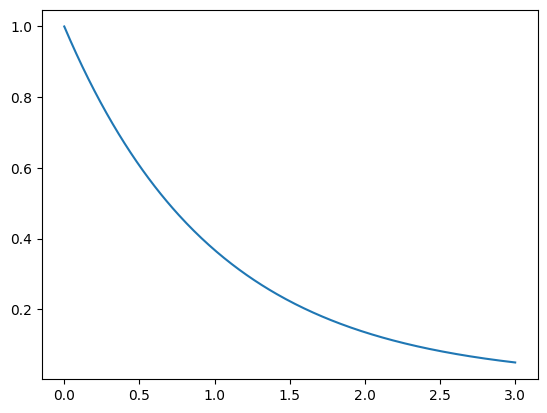

In [15]:
os_x = np.linspace(0,3, 300)
plt.plot(os_x, np.exp(-os_x));

Ta propozycja nie wystarcza, bo dane powinny być rozrzucone symetrycznie wokół wartości oczekiwanej. Korekta nasuwa się sama:
$$f(x)=\exp\left[ -|x\right|].$$

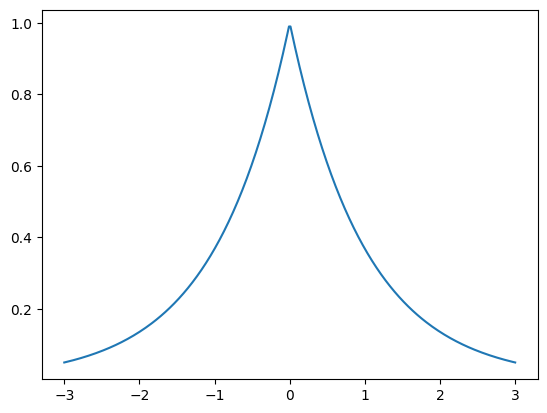

In [16]:
os_x = np.linspace(-3,3, 300)
plt.plot(os_x, np.exp(-abs(os_x)))

Niepokojąco wygląda jednak nieróżniczkowalność funkcji $f$ w wartości oczekiwanej. Ponadto wykładniczy spadek prawdopodobieństwa napotkania obserwacji wydaje się zbyt drastycznie maleć. Oto proste remedium na oba problemy na raz:
$$f(x)=\exp\left[ -x^2\right].$$

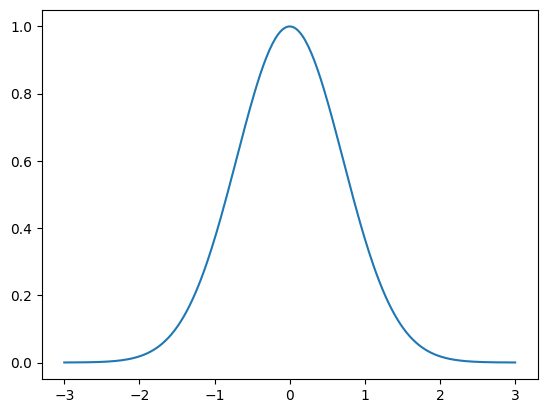

In [17]:
plt.plot(os_x, np.exp(-os_x**2));

Wartość oczekiwana nie musi leżeć w zerze, jej położenie zależy od miejsca zgrupowania danych. <br>
Wartość oczekiwaną oznacza się symbolem $\mu$. <br>
Aby ulokować $f(x)$ nad zadaną wartością $\mu$, wystarczy przesunąć argument do $x-\mu$: <br>
$$f(x)=\exp\left[ -(x-\mu)^2\right].$$

Ponadto zachodzi potrzeba uwzględnienia rozrzutu danych wokół $\mu$. <br>
W tym celu trzeba pomnożyć lub podzielić wykładnik przez drugi parametr, który oznaczymy $\sigma$. Wybierzemy dzielenie, aby większe wartości $\sigma$ opisywały większy rozrzut (odchylenie) danych od wartości oczekiwanej $\mu$:
$$\frac{x-\mu}{\sigma}.$$
Powyższy zabieg określany jest jako standaryzacja zmiennej $x$, zatem parametr $\sigma$ określa się mianem *odchylenia standardowego*. <br>
Otrzymujemy wzór:
$$f(x)=\exp\left[ -\left(\frac{x-\mu}{\sigma}\right)^2\right],$$
zapisywany w podręcznika zwyczajowo w postaci:
$$f(x)=\exp\left[ -\frac{(x-\mu)^2}{\sigma^2}\right].$$
Jeżeli ma on służyć jako rozkład, to musi spełnić warunek unormowania (pole pod całym wykresem ma być równe $1$).

In [18]:
def f(x, mu=0, sigma=1):
  return np.exp(-((x-mu)/sigma)**2)

from scipy import integrate
print(f'Pole pod wykresem: {integrate.quad(f, -np.inf, np.inf)[0]}')

Pole pod wykresem: 1.7724538509055159


Niestety, trzeba wykonać dodatkową pracę nad sprowadzeniem całki z $f(x)$ do $1$. <br>
Oto znormalizowana wersja funkcji $f(x)$, znana pod nazwą rozkładu normalnego:
$$ f(x; \mu, \sigma)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right].$$
Obecność $\pi$ we wzorze sugeruje, że rozkład normalny ma coś wspólnego z kołem. <br>
W komórce poniżej narysuj wykresy rozkładu normalnego dla różnych wartości parametrów $\mu$, $\sigma$. Każdorazowo sprawdź pole pod wykresem.

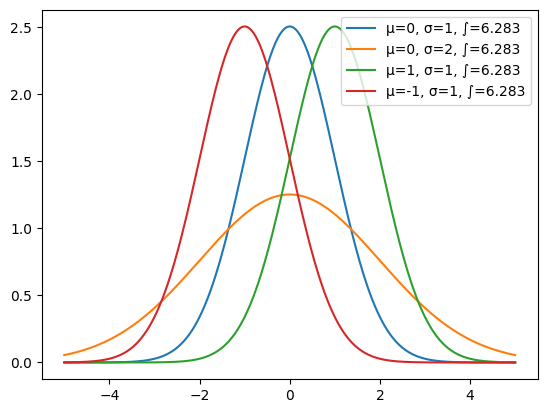

In [36]:
# Oto komórka do pracy własnej
def pdf(x: np.ndarray, mu: float=0, sigma: float=1) -> np.ndarray:
    """Probability density function of normal distribution."""
    return np.array( 1 / sigma * np.sqrt(2*np.pi) * np.exp((x - mu) ** 2 / (2 * sigma ** 2) * -1))

mu_and_sigmas = [[0, 1], [0, 2], [1, 1], [-1, 1]]
for mu, sigma in mu_and_sigmas:
    integral = integrate.quad(func=pdf, a=-np.inf, b=np.inf, args=(mu, sigma))[0]
    x = np.linspace(-5, 5, 500)
    y = pdf(x, mu, sigma)
    plt.plot(x, y, label=f"μ={mu}, σ={sigma}, ∫={round(integral, 3)}")

plt.legend()
plt.show()

Posługując się metodą maksymalnej wiarygodności (spójrz na wykład), można wyznaczyć analitycznie nieobciążone estymatory wartości $\mu$ i $\sigma$, które dają najlepsze dopasowanie rozkładu normalnego do zbioru danych $\left\{ x_i\right\}_{i=1}^N$:
$$\widehat{\mu} = \frac{1}{N}\sum_{i=1}^Nx_i,$$
$$\widehat{\sigma}^2 = \frac{1}{N}\sum_{i=1}^N(x_i-\mu)^2,$$
dla znanej wartości $\mu$ lub:
$$\widehat{\sigma}^2 = \frac{1}{N-1}\sum_{i=1}^N(x_i-\widehat{\mu})^2,$$
gdy oba parametry są estymowane z tego samego zbioru danych. <br>
**Ciekawostka**: gdy $N$ jest duże, nie ma większego znaczenia czy dzielisz przez $N$ czy przez $N-1$.

#### **Estymator nieparametryczny** <br>
Określona jest jedynie ogólna postać wzoru opisującego rozkład. <br>
Jego dokładna  postać zależy od liczby obserwacji zawartych w zbiorze danych. <br>
Rozkład może mieć pewne parametry, których wartość zależy od użytkownika lub od danych. <br>
Dopasowanie rozkładu do danych nie wymaga procesu optymalizacji.

**Estymator Parzena**. Niniejszy fragment notatnika jest inspirowany pierwszym rozdziałem książki:<br>
Piotr Kulczycki, [Estymatory jądrowe w analizie systemowej](https://www.ibspan.waw.pl/~kulpi/publ/Kulczycki_-_Estymatory_jadrowe_w_analizie_systemowej_-_WNT_-_2005.pdf), WNT 2005.

Zaimplementujemy rozkład normalny w nieco inny sposób niż funkcję $f$. <br>
Utworzymy funkcję $K$, która jest równoważna funkcji $f$ dla $\mu=0$ i $\sigma=1$:
\begin{equation}
K(x)=\frac{1}{\sqrt{2\pi}}\exp\left[-\frac{x^2}{2}\right].
\tag{2}
\end{equation}
Nosi ona nazwę **funkcji jądrowej** (ang. *kernel*). Funkcja musi spełnić pewne warunki, aby zasługiwała na tę nazwę (patrz: wykład lub książka podana wyżej). Ciekawe przykłady innych funkcji jądrowych można znaleźć w [tym artykule](https://arxiv.org/pdf/1212.2812.pdf).


In [37]:
def K(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

Aby ulokować maksimum funkcji $K$ w punkcie $x_i$ pochodzącym ze zbioru danych, wystarczy wywołać:
$$K(x-x_i).$$
Uwzględnienie rozproszenia wymaga dzielenia przez parametr, który oznaczać będziemy przez $h$:
$$K\left(\frac{x-x_i}{h}\right).$$
Parametr $h$ pełni tę samą rolę, co wcześniej $\sigma$, ale trzeba jakoś podkreślić różnicę między stosowaniem funkcji jako rozkładu i jako jądra estymatora nieparametrycznego. Umowna nazwa $h$ to **szerokość okna** (ang. *bandwidth*). <br>
Rozciągnięcie wykresu $K$ o czynnik $h$ spowoduje $h$-krotny wzrost pola pod jej wykresem. Unormowanie funkcji jądrowej osiągnąć można w prosty sposób:
\begin{equation}
\frac{1}{h}K\left(\frac{x-x_i}{h}\right).
\tag{3}
\end{equation}



Dane pomiarowe $\left\{x_i\right\}_{i=1}^N$ wpisane ręcznie. 

In [38]:
X = np.array([1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4])

Ustalamy arbitralnie $h=0.3$. Ta wartość może być wynikiem kłótni ekspertów.

Załóżmy, że pomiary przychodzą pojedynczo w takiej kolejności, jak w powyższej serii. Przypominam, że $x_1$ w zbiorze danych odpowiada ```X[0]``` w kodzie. <br>
Gdy dostępny jest tylko jeden pomiar $x_1$, to jedyna rozsądna możliwość rozpięcia nad nim rozkładu jest taka:
$$\frac{1}{h}K\left( \frac{x-x_1}{h}\right).$$

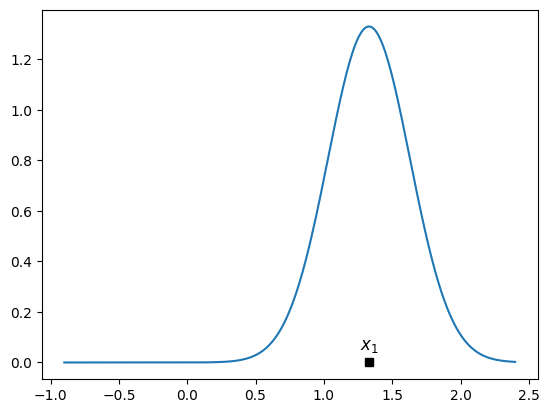

In [39]:
os_x = np.linspace(X.min()-1, X.max()+1, num=300)

h = .3

os_y1 = K((os_x - X[0])/h)/h 

plt.plot(os_x, os_y1)
plt.plot(X[0],0, 's', color='black')
plt.annotate(r'$x_1$', xy=[X[0],0.05], horizontalalignment='center', fontsize=12)
plt.show()

Pojawia się drugi pomiar $x_2$. Jemu również można przydzielić funkcję
$$\frac{1}{h}K\left( \frac{x-x_2}{h}\right),$$
ale obie trzeba połączyć w jeden rozkład:
$$\frac{1}{2}\Bigg[\frac{1}{h}K\left( \frac{x-x_1}{h}\right) + \frac{1}{h}K\left( \frac{x-x_2}{h}\right)\Bigg].$$
Dzielenie przez $2$ pozwala zachować unormowanie całego rozkładu.

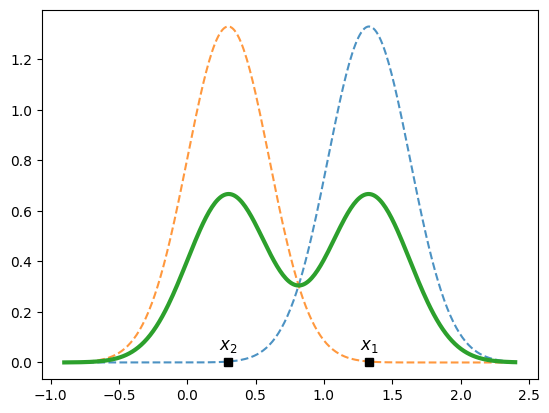

In [52]:
h = .3
os_y2 = K((os_x - X[1])/h)/h 
os_y = (K((os_x - X[0])/h)/h + K((os_x - X[1])/h)/h)/2 

plt.plot(os_x, os_y1, alpha=0.8, linestyle='dashed')
plt.plot(os_x, os_y2, alpha=0.8, linestyle='dashed')
plt.plot(os_x, os_y, linewidth=3)
plt.plot(X[0],0, 's', color='black')
plt.plot(X[1],0, 's', color='black')
plt.annotate(r'$x_1$', xy=[X[0],0.05], horizontalalignment='center', fontsize=12)
plt.annotate(r'$x_2$', xy=[X[1],0.05], horizontalalignment='center', fontsize=12)
plt.show()

**Zbadaj** wpływ doboru wartości parametru $h$ na rozkład.

Powinno być już teraz jasne, skąd się bierze wzór na **estymator Parzena**: 
\begin{equation}
f(\mathbf{x}) = \frac{1}{Nh^d} \sum_{i=1}^{N} K\left(\frac{\mathbf{x} - \mathbf{x}_i}{h}\right),
\end{equation}
gdzie  $d$ oznacza wymiarowość wektora $\mathbf{x}$, czyli liczbę cech. W podanych przykładach $d=1$.

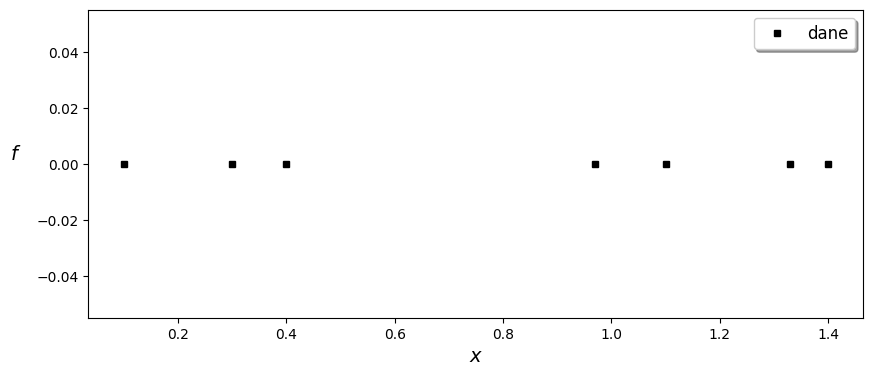

In [53]:
h_values = []
N = X.size

plt.figure(figsize=(10,4))
for h in h_values:
  suma = 0
  for nr, pomiar in enumerate(X):
    suma += K((os_x-pomiar)/h)
    plt.annotate(r'$x_{}$'.format(nr+1), xy=[X[nr],0.05], horizontalalignment='center', fontsize=12)
  os_y = suma/(h*N)
  plt.plot(os_x, os_y, label=f'h = {h}')
  

plt.plot(X, np.zeros_like(X) , 's', markersize=5, color='black', label='dane')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f$', fontsize=14, rotation='horizontal', labelpad=15)
plt.legend(fontsize=12, shadow=True)
plt.show()

**Zastosuj** estymator Parzena do prawdziwego zbioru danych przedstawionego na początku notatnika. 

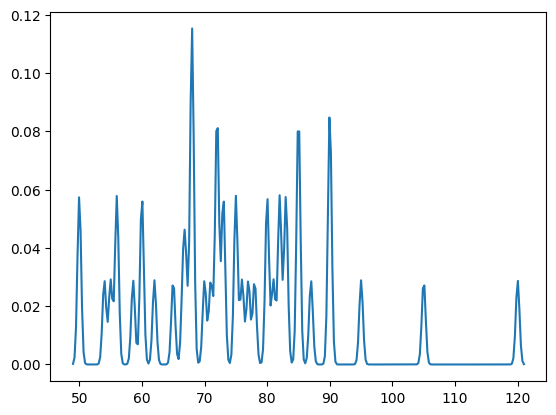

In [56]:
#  komórka na wykonanie zadania
def parzen_estimator(X: np.ndarray, h: float=0.3, y_size: int=300) -> np.ndarray:
  """
  Parzen's estimator for vector X with one dimensional features.

  :param X: a vector of observations
  :param h: bandwidth (corresponds to σ)
  :param y_size: a size of returned vector of estimations
  :return: estimated values of density probablility function for sampled domain
  """
  x = np.linspace(X.min()-1, X.max()+1, num=y_size)

  def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)
  sigma_K = np.sum([K((x - x_i) / h) for x_i in X], axis=0)
  y = sigma_K / (len(X) * h)

  return x, y


plt.plot(*parzen_estimator(dane['waga']))
plt.show()

Wykorzystaj do wykonania tego samego zadania procedurę [```kdeplot```](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) biblioteki ```seaborn```. Sposób jej użycia przedstawiony jest w podanej dokumentacji.

<Axes: xlabel='waga', ylabel='Density'>

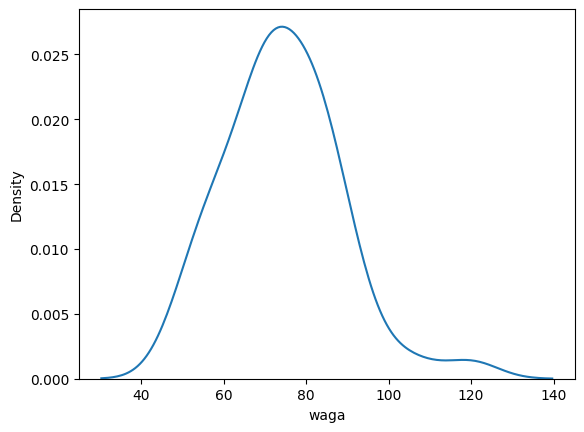

In [59]:
import seaborn as sns
#  komórka na wykonanie zadania
sns.kdeplot(dane['waga'])

Zbadaj możliwości procedur ```kdeplot``` oraz [```jointplot```](https://seaborn.pydata.org/generated/seaborn.jointplot.html) w zakresie estymacji i wizualizacji rozkładów danych dwuwymiarowych. 

In [ ]:
dane_sub = dane[['waga', 'wzrost']]
display(dane_sub.sample(5))

# komórka na wykonanie zadania


**Bonus** <br>
Oto szybki i wygodny sposób na wstępne przyjrzenie się danym pomiarowym.

In [ ]:
sns.pairplot(dane, hue='płeć', height=2.5)